# TEXT ANALYSIS & INFORMATION RETRIEVAL

# Mathieu VANDECASTEELE - M2 SID Janv. 2019

# Université de Rouen

Ce TP est à destination de Pierre Héroux, enseignant-chercheur à l'université de Rouen. Il se décompose en deux parties : l'implémentation d'un système d'Information Retrieval dans un premier temps et la classification de textes dans un second.

# 1. Information Retrieval

Rappel des Consignes : 
* Implanter un crawler, permettant d'extraire récursivement une liste d'URL à partir d'une liste de germes
* Extraire le vocabulaire utilisé par un ensemble de documents pour lesquels on dispose d'une liste d'URL
* Fournir une représentation vectorielle de chacun des documents précédents basé sur le vocabulaire extrait
* Proposez les 10 premiers documents d'une liste ordonnées sur la base d'un score de correspondance entre requête et document.

In [29]:
# Imports nécessaires
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import urllib.request as urlreq
import re
import string
import json
from sklearn.feature_extraction.text import TfidfTransformer,  CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

In [20]:
# Fonctions codées pour cette partie de TP

def get_urls_from_a_webpage(url):
    """
        Retourne tous les URLs intéressants d'une page Wikipédia française
    """
    url_list = []
    html_page = urlreq.urlopen(url)
    soup = BeautifulSoup(html_page)
    for link in soup.findAll('a'):
        temp = link.get('href')
        # On s'assure que le lien soit correct, qu'il redirige vers une page externe et non un fichier.
        if temp and temp[0] == '/': 
            if temp[1]=='/':
                url = "https:"+temp
            else : 
                url = "https://fr.wikipedia.org"+temp
            if not (url[len(url)-3:len(url)]=='jpg' or url[len(url)-10:len(url)-3]=='section' or url[len(url)-9:len(url)-2]=='section' or url == 'https://fr.wikipedia.org/wiki/Cat%C3%A9gorie:Article_avec_une_section_vide_ou_incompl%C3%A8te'):
                url_list.append(url)
    return (np.unique(url_list)).tolist()
  
    
def get_full_list_urls(start_url_list):
    """
        Retourne tous les URLs d'une liste de germes
    """        
    final_list = []
    
    for start_url in start_url_list:
        
        leveltwo = []
        print('Exploring... '+str(start_url))
        leveltwo.extend(get_urls_from_a_webpage(start_url))
        
        final_list.append(start_url)
        final_list.extend(leveltwo)
       
    return (np.unique(final_list)).tolist()
    
    
    
def get_webpage_raw_text(url):
    """
        Crée un dictionnaire du contenu d'une page web.
    """
    dic = {}
    dic['title'] = []
    dic['url']= [url]
    dic['subtitles'] = []
    dic['content'] = []
    
    subtitle_tags = ['h2','h3','h4','h5','h6']
    
    try :
        html_page = urlreq.urlopen(url)
        soup = BeautifulSoup(html_page)
        for link in soup.findAll('h1'):
            dic['title'].append(link.text)
        for tag in subtitle_tags:
            for link in soup.findAll(tag):
                dic['subtitles'].append(link.text)
        dic['content'] = soup.body.text
    except :
        print(str(url)+' is a non valid URL for parsing')
    finally :
        return dic


def get_text_cleaned(raw_text):
    """
        Nettoie le texte passé en entrée. On s'assure de retirer toutes les ponctuations, les majuscules, les espaces en trop et on s'assure enfin que aucun mots ne sont collés entre eux.
    """
    table = str.maketrans('', '', string.punctuation + '’°“‘”—→»«®©℠↑²™')
    cleaned = raw_text.translate(table).lower().rstrip().lstrip()
    cleanedplus = cleaned.replace('\n',' ').replace('\xa0',' ').replace('\t',' ').replace('  ',' ')
    cleaned_better = cleanedplus.replace('  ',' ').replace('  ',' ').replace('  ',' ').replace('  ',' ')
    cleaned_best = cleaned_better.replace('  ',' ').rstrip().lstrip()
    return cleaned_best


def clean_dic_content(dictionnary):
    """
        Prend un dictionnaire créé d'une page web en entrée et nettoie son contenu.
    """
    text_to_clean = dictionnary['content']
    text_cleaned = get_text_cleaned(text_to_clean)
    dictionnary['content']=[text_cleaned]
    return dictionnary


def make_document_dictionnary(url):
    """
        Crée un dictionnaire nettoyé d'une page web.
    """
    dic = get_webpage_raw_text(url)
    if ((dic['content'] != []) and (dic != None)):
        return clean_dic_content(dic)

    
def make_a_Query(query, text_list):
    """
        Permet de faire une requête. Plusieurs étapes : Bag fo Words pour chaque document + TFIDF + calcul du score avec un dot product.
    """
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer.fit(text_list)
    
    score = -tfidf_vectorizer.transform(text_list) * tfidf_vectorizer.transform(query).T.toarray().sum(axis = 1)
    rank = 0
                                        
    for i in (np.argsort(score)[0:10]):
        rank = rank+1
        print(str(rank)+"-> "+str(url_list[i])+" , score de : %.2f" % (-score[i]))

On définit une liste d'URL de base comme étant les germes de notre crawler. Pour économiser du temps de calcul nous n'allons prendre que 2 URLS : un axé histoire et un autre axé informatique.

In [ ]:
liste = []
liste.append("https://fr.wikipedia.org/wiki/Cinqui%C3%A8me_R%C3%A9publique_(France)")
liste.append("https://fr.wikipedia.org/wiki/Bill_Gates")

url_list = get_full_list_urls(liste)
print(len(url_list))

Maintenant nous créons les dictionnaires et nous les stockons dans une liste : certaines pages ne peuvent pas être parsées et par conséquent nous retournons des erreurs dans ces situations.

In [4]:
doc_list = []
for url in url_list:
    doc_list.append(make_document_dictionnary(url))

https://fr.wikipedia.org/wiki/Wikipédia:Contact is a non valid URL for parsing


In [7]:
# Récupérer chaque contenu dans une liste :
# L'idée est d'abord de nettoyer la liste de dictionnaire et de s'assurer qu'il n'y a pas de dictionnaires vides ou de dictionnaires possédant un contenu vide. 
# Le parsing des pages web n'est pas tout le temps parfait.
# Si il y a un problème, un indice de dictionnaire à supprimer dans la liste des URLs est retourné.
cleaned_doc_list = []
indice = 0
for doc in doc_list :
    if (doc != None):
        cleaned_doc_list.append(doc)
        indice = indice+1
    else :
        print("a supprimer : "+str(indice))
        indice = indice+1
        
# Nous supprimons l'élément d'indice 787.       
#del doc_list[787]

        
# Nous créons un vecteur de textes où chaque élément est donc un des textes correspondant à un URL. 
texts_list = []
for doc in cleaned_doc_list :
    try :
        if (doc['content'] != None) and (doc['url'] != None):
            texts_list.append(doc['content'][0])
    except :
        print(str(doc)+"Erreur Document Vide")
        
# à la fin nous devons avoir un dictionnaire nettoyé de textes et une liste d'URL de même taille et ordonnés de la même façon !!

a supprimer : 787


Nous faisons deux requêtes d'essai :

In [21]:
query = "Informatique".split(" ")   
print('Résultat : ' + " ".join(query))
make_a_Query(query,texts_list)    

print('')
query = "Charles de Gaulle".split(" ")
print('Résultat : ' + " ".join(query))
make_a_Query(query,texts_list)    


Résultat : Informatique
1-> https://fr.wikipedia.org/wiki/Cat%C3%A9gorie:Portail:Informatique/Articles_li%C3%A9s , score de : 0.40
2-> https://fr.wikipedia.org/wiki/Informatique , score de : 0.23
3-> https://fr.wikipedia.org/wiki/Informaticien , score de : 0.19
4-> https://fr.wikipedia.org/wiki/Portail:Logiciel , score de : 0.17
5-> https://fr.wikipedia.org/wiki/1975_en_informatique , score de : 0.15
6-> https://fr.wikipedia.org/wiki/1985_en_informatique , score de : 0.15
7-> https://fr.wikipedia.org/wiki/Interpr%C3%A8te_(informatique) , score de : 0.11
8-> https://fr.wikipedia.org/wiki/Logiciel , score de : 0.09
9-> https://fr.wikipedia.org/wiki/Programmation_informatique , score de : 0.08
10-> https://fr.wikipedia.org/wiki/British_Computer_Society , score de : 0.07

Résultat : Charles de Gaulle
1-> https://fr.wikipedia.org/wiki/Charles_de_Gaulle , score de : 1.11
2-> https://fr.wikipedia.org/wiki/Crise_de_mai_1958 , score de : 0.78
3-> https://fr.wikipedia.org/wiki/Gouvernement_provi

Ces résultats sont plutôt satisfaisants. Ils pourraient néanmoins être améliorés avec un nettoyage différent, l'utilisation de Lemmes ou encore avec + de données.

J'ai également dans les dictionnaires penser à stocker séparemment les titres et sous titres des pages, il serait sûrement possible d'améliorer les résultats en appliquant une pondération plus important sur les mots de ces derniers.

# 2. Text Analysis

* Illustrez l'adéquation d'un ensemble de documents avec la loi de Zipf
* Utiliser découper un corpus multi-lingue en une base de d'apprentissage et une base de test et proposez un classifieur pour la reconnaissance de la langue.
* Entraînez sur un corpus un modèle génératif de texte déterminant la probabilité d'un mot sachant le précédent. Utilisez-le pour générer des séquences à partir d'un terme. 
* Chaque nouveau mot wt de la séquence devra être généré aléatoirement avec une probabilité égale à P(wt|wt−1).

In [28]:
# Imports nécessaires
import nltk
from nltk.corpus import reuters
from collections import Counter
from operator import itemgetter
from sklearn.model_selection import GridSearchCV

La loi de Zipf est une observation empirique concernant la fréquence des mots dans un texte. En général, il est dit que les stop words, c'est à dire les mots les plus courants dans une langue sont exponentiellement beaucoup plus fréquents que les autres mots. Illustrons là avec un ensemble de documents :

In [2]:
# j'importe le corpus reuters et crée une liste de tuples (mots, occurences)
reuters_words = [w.lower() for w in reuters.words()]
words = set(reuters_words)
counts = [(w, reuters_words.count(w)) for w in words]


In [3]:
# Nombre de mots dans le corpus :
print(len(reuters.words()))

1720901


In [4]:
# je la trie dans l'ordre décroissant
sorted_data = sorted(counts, key=lambda tup:(-tup[1], tup[0]))

In [5]:
sorted_data[0:15]

[('.', 94687),
 (',', 72360),
 ('the', 69277),
 ('of', 36779),
 ('to', 36400),
 ('in', 29253),
 ('and', 25648),
 ('said', 25383),
 ('a', 25103),
 ('mln', 18623),
 ('s', 15680),
 ('vs', 14341),
 ('for', 13782),
 ('-', 13705),
 ('dlrs', 12417)]

La loi semble être valide ici, traçons la courbe :

In [7]:
words_zipf = [tup[0] for tup in sorted_data]

In [10]:
occurences_zipf = [tup[1] for tup in sorted_data]
word_number = 1720901
frequences_zipf = [x / word_number for x in occurences_zipf]

In [14]:
frequences_zipf[0:10]

[0.055021758950689205,
 0.042047741270415905,
 0.040256237866094564,
 0.021371944115320986,
 0.021151710644598382,
 0.016998653612264738,
 0.014903820731117014,
 0.014749831628896723,
 0.014587126162399813,
 0.010821656794899881]

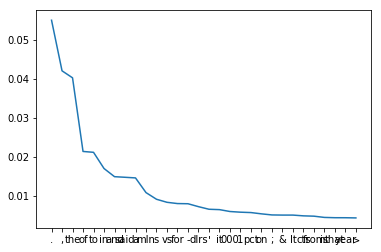

In [17]:
plt.figure()
plt.plot(words_zipf[0:30],frequences_zipf[0:30])

On remarque bien cette différence fréquentielles qui a l'allure d'une courbe exponentielle, on valide donc la théorie de Zipf.

**Maintenant**, faisons une classification de langages. J'ai choisi de classer des langues latines car NLTK possède déjà pas mal de données à utiliser dans ces langues.

In [26]:
# On récupère les données via le corpus udhr :
languages = ['Portuguese_Portugues-Latin1', 'Swedish_Svenska-Latin1','French_Francais-Latin1','English-Latin1','German_Deutsch-Latin1','Spanish_Espanol-Latin1','Italian_Italiano-Latin1']
dataX = []
datay = []
for language in languages :
    text = nltk.corpus.udhr.sents(language)
    for sentences in text:
        dataX.append(" ".join(sentences))
        datay.append(language)
        
def most_popular_elements_in_list(list_to_top, number_wanted):
    return dict(Counter(list_to_top).most_common(number_wanted))

most_popular_elements_in_list(datay,7)

{'Swedish_Svenska-Latin1': 121,
 'Portuguese_Portugues-Latin1': 80,
 'English-Latin1': 67,
 'German_Deutsch-Latin1': 60,
 'Spanish_Espanol-Latin1': 58,
 'French_Francais-Latin1': 57,
 'Italian_Italiano-Latin1': 51}

On constate que le suédois et le portugais sont + présents que les autres langues mais on ne peut parler réellement de sur-représentation.

On split les données en faisant un dataset d'entraînement et un autre de test. Nous ferons de la **crossvalidation** pour valider et généraliser le modèle.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(dataX,datay,test_size = 0.33)

Je choisis d'utiliser une représentation Bag Of Words avec TF-IDF :

In [33]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
X_train_tf = vectorizer.transform(X_train)
X_test_tf = vectorizer.transform(X_test)

classifier = MultinomialNB()
parameters = {'alpha':[1]}
gs = GridSearchCV(classifier, parameters, cv = 5)
gs.fit(X_train_tf,y_train)

confusion_matrix(y_test,gs.predict(X_test_tf))
print(classification_report(y_test,gs.predict(X_test_tf)))

                             precision    recall  f1-score   support

             English-Latin1       1.00      0.96      0.98        28
     French_Francais-Latin1       1.00      0.96      0.98        23
      German_Deutsch-Latin1       1.00      1.00      1.00        11
    Italian_Italiano-Latin1       1.00      1.00      1.00        14
Portuguese_Portugues-Latin1       1.00      0.71      0.83        35
     Spanish_Espanol-Latin1       1.00      1.00      1.00        14
     Swedish_Svenska-Latin1       0.76      1.00      0.87        39

                  micro avg       0.93      0.93      0.93       164
                  macro avg       0.97      0.95      0.95       164
               weighted avg       0.94      0.93      0.93       164



Nous obtenons des très bons résultats avec de la CrossValidation et TF-IDF. Ces résultats peuvent sûrement être supérieurs avec un autre classifieur comme par exemple un SVM.

**Dernier point, faire de la génération de texte à partir d'un mot précédent :**

On est typiquement sur une utilisation d'un modèle Bi-Gram, je me suis inspiré d'un code de **Yann Soulard** pour implémenter cela avec la Déclaration Universelle des droits de l'Homme :

In [35]:
texte = nltk.corpus.udhr.words('French_Francais-Latin1')
dataX = []
for sents in texte:
    dataX.append(sents)
      
def compute_transition_matrix(seq):
    """ Function for computing the transition matrix between characters for a given sequence in input. """
    unique_states = np.unique(seq)
    nb_states = len(unique_states)

    A = np.zeros((nb_states+1, nb_states+1)) # +1 = an additional state for beginning or ending a sentence.
    # count the transitions
    for i in range(len(seq)-1):

        if seq[i] in ['.', '!', '?']:
            A[np.where(unique_states == seq[i]), -1] += 1
            if seq[i+1]==' ' and i+2<len(seq): # If this is a space, we focus on the next character
                A[-1, np.where(unique_states == seq[i + 2])] += 1
                i += 1
            else:
                A[-1, np.where(unique_states == seq[i + 1])] += 1
        else:
            A[np.where(unique_states == seq[i]), np.where(unique_states == seq[i + 1])] += 1
    # normalization
    for i in range(nb_states+1):
        norm = A[i,:].sum()
        A[i,:] /= norm
    return A


def generate_sequences(set_states, A, N):
    """ Generate N sequences using the transition matrix A and according to the possible states defined in set_states """

    list_seq_gen = []
    for i in range(N):

        seq_gen = ''
        elmt_gen = np.random.choice(set_states, p=A[-1,:-1]) # first term
        index_elmt = int(np.where(set_states==elmt_gen)[0])
        seq_gen += elmt_gen
        while elmt_gen not in ['.', '!', '?']:
            #print(elmt_gen, index_elmt)
            elmt_gen = np.random.choice(set_states, p=A[index_elmt,:-1])
            index_elmt = int(np.where(set_states == elmt_gen)[0])
            seq_gen += elmt_gen+" "

        list_seq_gen.append(seq_gen)

    return list_seq_gen


unique_states = np.unique(dataX)

# Modélisation avec la matrice de transition.
transitions = compute_transition_matrix(dataX)

# Générons les phrases :
n = 10
generated_sequences = generate_sequences(unique_states, transitions, n)

print("Générations : \n")
for gen_sequence in generated_sequences:
    print((gen_sequence+"\n\n"))

Générations : 

Articlepremier Tous sont doués de maladie , la femme , en droits et à un salaire égal et ont proclamé à la même protection de faire partie d ' homme Préambule Considérant que les garanties nécessaires ; cette volonté . 


Article15 Tout individu a droit à l ' Organisation des droits et de son bien - fondé de sa famille , ni du droit à des conditions de l ' exprimer par l ' homme ne sera l ' ordre national et ceux de poursuites réellement fondées sur le logement , de la traite des agissements contraires aux principes des Nations Unies , de conscience et de faire partie d ' égalité , l ' homme et satisfaisantes de s ' Etat . 


Article16 A partir de raison et complétée , tant en commun à sa famille , il est l ' un monde , sans aucune distinction à la liberté et celui de barbarie qui lui sont engagés à favoriser le droit à la dignité et de toutes leurs droits de pensée , Considérant qu ' homme soient nés dans le cas de ses moyens de changer de réunion et plein consentement

/Users/mathieuvdc/.virtualenvs/textA/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


**Pour conclure** sur cette génération de textes, on se rend vite compte que c'est imparfait du fait de l'utilisation uniquement du mot précédent. Il faudrait tester avec plus qu'un seul et les résultats seront sûrement meilleurs. Les résultats actuels restent quand même relativement satisfaisants.